# Data Preprocessing 
- normalize/standartize ratio
    - fix skewness
    - try all scales (min-max, standard, normalize, z-scale)
- feature selection
    - remove constant features (eg. std() = 0, unique values = 1)
    - highly correlated features
    - try 1 or 2 different feature selection models

In [79]:
%load_ext autoreload
%autoreload 2

import shutil, os, io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mylib.ml_helpers import *

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import svm
from sklearn.model_selection import cross_val_score

seed = 420

DATA_ROOT = 'data/forest-cover-type'
DATA_TRAIN = DATA_ROOT+'/train.csv'
DATA_TEST = DATA_ROOT+'/test.csv'

df_train = pd.read_csv(DATA_TRAIN)

features_numerical = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

features_categorical = ['Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40']

label = ['Cover_Type']

remove_columns = ['Id']

remove_constant_features = get_constant_features(df_train)

remove_columns.extend(remove_constant_features)

df_train.drop(remove_columns, axis=1, inplace=True)

features = df_train.drop(label, axis=1)
labels = df_train[label]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scaling
- min max
- standard
- z-scale

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

features_minmax = features.copy()
labels_minmax   = labels.copy()
features_minmax[features_numerical] = MinMaxScaler().fit_transform(features_minmax[features_numerical])

features_std = features.copy()
labels_std   = labels.copy()
features_std[features_numerical] = StandardScaler().fit_transform(features_std[features_numerical])

features_norm = features.copy()
labels_norm   = labels.copy()
features_norm[features_numerical] = Normalizer().fit_transform(features_norm[features_numerical])

scale_name =['non-scaled', 'standard-scale', 'min-max-scale', 'normalized']
all_transformations = [features, features_minmax, features_std, features_norm]
all_labels = [labels, labels_minmax, labels_std, labels_norm]

# Feature Selection
## RandomForestClassifier


In [8]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

feat_importances = []

for i in range(0, len(all_transformations)):
    X = all_transformations[i].values
    y = all_labels[i].values.ravel()
    
    model = RandomForestClassifier(n_estimators=100) 
    model.fit(X, y) 
    importances = model.feature_importances_
    
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    feat_importances.append(feature_importance_normalized)

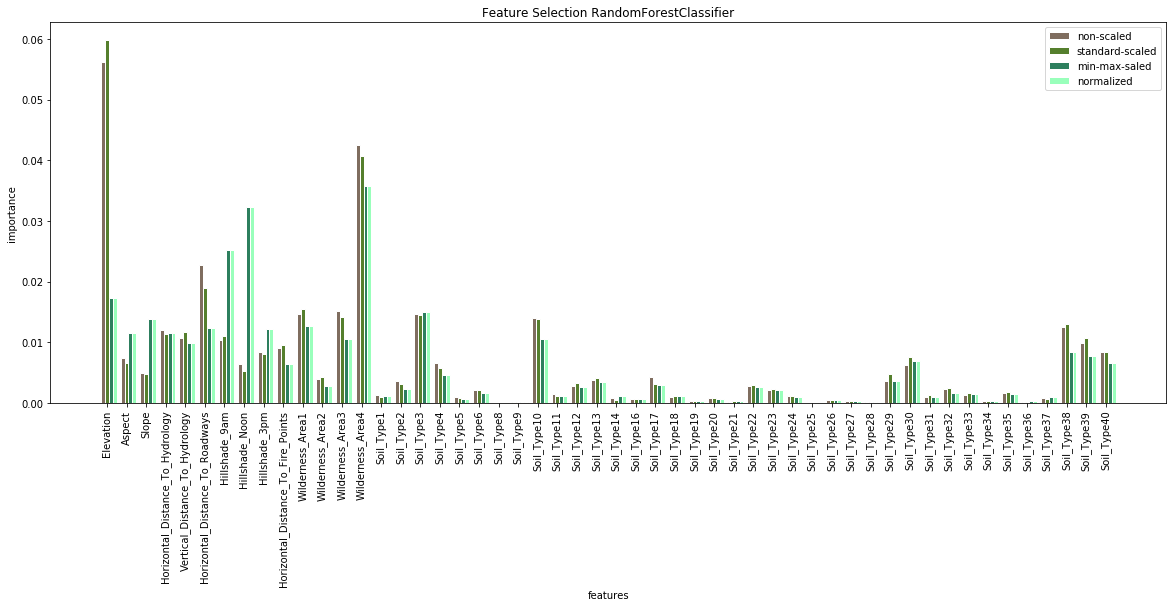

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,7))

# set height of bar
bars1 = feat_importances[0]
bars2 = feat_importances[1]
bars3 = feat_importances[2]
bars3 = feat_importances[3]
 
# Set position of bar on X axis
barWidth = 0.2
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

model_name = type(model).__name__
 
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='non-scaled')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='standard-scaled')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='min-max-saled')
plt.bar(r4, bars3, color='#99ffbb', width=barWidth, edgecolor='white', label='normalized')

plt.ylabel('importance')
plt.xlabel('features')
plt.title('Feature Selection '+ model_name)
plt.xticks([r + barWidth for r in range(len(bars1))], all_transformations[i].columns, rotation=90)
 
plt.savefig('random_forest_feature_selection.png')
plt.legend()
plt.show()

# Feature Selection
## Correlation 

-> see function get_selected_correlation_features in helpers

# ML Classification
- choose classifiers
    - test all transformations with all feature selections to build the 'best' data set

In [25]:
feature_select_random_forrest = [0, 0.05, 0.1, 0.15, 0.2, 0.3]

feature_select_correlation = [0.05, 0.10, 0.12, 0.15, 0.18, 0.2, 0.3]

results = []

# all transformation scales
for i in range(len(all_transformations)):
    print('>Transformaion Scale ',scale_name[i])
    
    # feature select random forrest
    for j in range(len(feature_select_random_forrest)):
        
        valid_col_names = get_feature_selected_columns(feature_select_random_forrest[j], feat_importances[i],  all_transformations[i].columns)
    
        ''' build train-test data '''
        features_train = all_transformations[i][valid_col_names].values
        labels_train = all_labels[i].values.ravel()
        seed = 42
        X_train, X_test, y_train, y_test = train_test_split(features_train, labels_train, test_size=0.20, random_state=seed)        
        
        ''' RF '''
        model = RandomForestClassifier(n_estimators=100, random_state=seed)
        model.fit(X_train, y_train)
        RF_pred = model.predict(X_test)
        RF_acc = accuracy_score(y_test, RF_pred)
        results.append(['RF', scale_name[i], 'RF-select', feature_select_random_forrest[j], RF_acc])
        print('\t RF pred. accuracy ', RF_acc)

        ''' NB '''
        NB = GaussianNB()
        y_pred = NB.fit(X_train, y_train)
        NB_pred = NB.predict(X_test)
        NB_acc = accuracy_score(y_test, NB_pred)
        results.append(['NB', scale_name[i], 'NB-select', feature_select_random_forrest[j], NB_acc])
        print('\t NB pred. accuracy ', NB_acc)


    # feature select by correlation threshold
    for j in range(len(feature_select_correlation)): 
        
        tmp_features = all_transformations[i]
        tmp_features[label] = all_labels[i]
        valid_corr_names = get_selected_correlation_features(tmp_features, feature_select_correlation[j], label)        

        ''' build train-test data '''
        features_train = all_transformations[i][valid_corr_names].values
        labels_train = all_labels[i].values.ravel()        
        seed = 42
        X_train, X_test, y_train, y_test = train_test_split(features_train, labels_train, test_size=0.20, random_state=seed)        
        
        ''' RF '''
        model = RandomForestClassifier(n_estimators=100, random_state=seed)
        model.fit(X_train, y_train)
        RF_pred = model.predict(X_test)
        RF_acc = accuracy_score(y_test, RF_pred)
        results.append(['RF', scale_name[i], 'Correlation-select', feature_select_correlation[j], RF_acc])
        print('\t RF pred. accuracy ', RF_acc)
        
        ''' NB '''
        NB = GaussianNB()
        y_pred = NB.fit(X_train, y_train)
        NB_pred = NB.predict(X_test)
        NB_acc = accuracy_score(y_test, NB_pred)
        results.append(['NB', scale_name[i], 'Correlation-select', feature_select_correlation[j], NB_acc])
        print('\t NB pred. accuracy ', NB_acc)
        

>Transformaion Scale  non-scaled
	 >Model-selection RF 	
	 RF pred. accuracy  0.8707010582010583
	 NB pred. accuracy  0.6008597883597884
	 >Model-selection RF 	
	 RF pred. accuracy  0.8707010582010583
	 NB pred. accuracy  0.6008597883597884
	 >Model-selection RF 	
	 RF pred. accuracy  0.8667328042328042
	 NB pred. accuracy  0.6008597883597884
	 >Model-selection RF 	
	 RF pred. accuracy  0.8673941798941799
	 NB pred. accuracy  0.5985449735449735
	 >Model-selection RF 	
	 RF pred. accuracy  0.8687169312169312
	 NB pred. accuracy  0.5965608465608465
	 >Model-selection RF 	
	 RF pred. accuracy  0.8703703703703703
	 NB pred. accuracy  0.5929232804232805
		 >Model-selection Correlation 	
	 RF pred. accuracy  0.8687169312169312
	 NB pred. accuracy  0.6028439153439153
		 >Model-selection Correlation 	
	 RF pred. accuracy  0.8740079365079365
	 NB pred. accuracy  0.5988756613756614
		 >Model-selection Correlation 	
	 RF pred. accuracy  0.8716931216931217
	 NB pred. accuracy  0.5958994708994709
	

In [101]:
def plot_pot(df, alg='RF', filename='file.png', title='420'):
    df = df[df['alg'] == alg]
    df['merged'] = df['scale'].map(str)+'_'+df['model_selection'].map(str)+'_thresh_'+df['threshold'].map(str)

    benchmark = df[(df['scale'] == 'non-scaled') & (df.threshold == 0.0)].accuracy.values[0]
    df_higher = df[df.accuracy >= benchmark] 
    df_lower = df[df.accuracy < benchmark] 
    df_best = df[df.accuracy == df.accuracy.max()] 

    ''' plot figure '''
    fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
    ax.set_ylim(df.accuracy.min()-0.005,df.accuracy.max()+0.005)
    plt.xticks(rotation=90)
    ax.set_xlabel('Parameter-Combination')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)

    ax.bar(df_higher.merged, df_higher.accuracy, align='center', alpha=0.5, color = 'green', label='> benchmark')
    ax.bar(df_lower.merged, df_lower.accuracy, align='center', alpha=0.5, color = 'blue', label='< benchmark')
    ax.bar(df_best.merged, df_best.accuracy, align='center', alpha=0.8, color = 'darkgreen', label='best setting')

    if df_best.shape[0] != 0 and df.shape[1] != 0:
        ax.legend(framealpha=0.5)
    plt.savefig(filename)
    plt.show()

    return df_best


''' format results '''
column_names = ['alg', 'scale', 'model_selection', 'threshold', 'accuracy']
df = pd.DataFrame(results, columns=column_names)
df.to_csv('_results/a.csv', index=False)

/home/jtweber/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


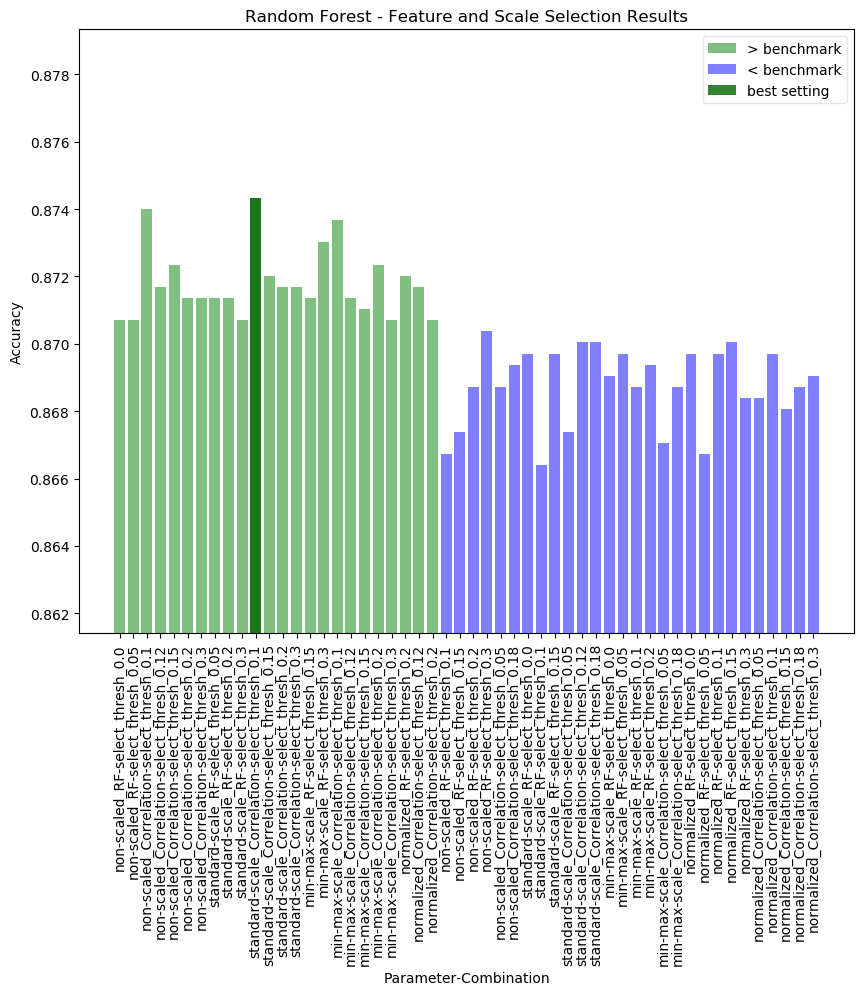

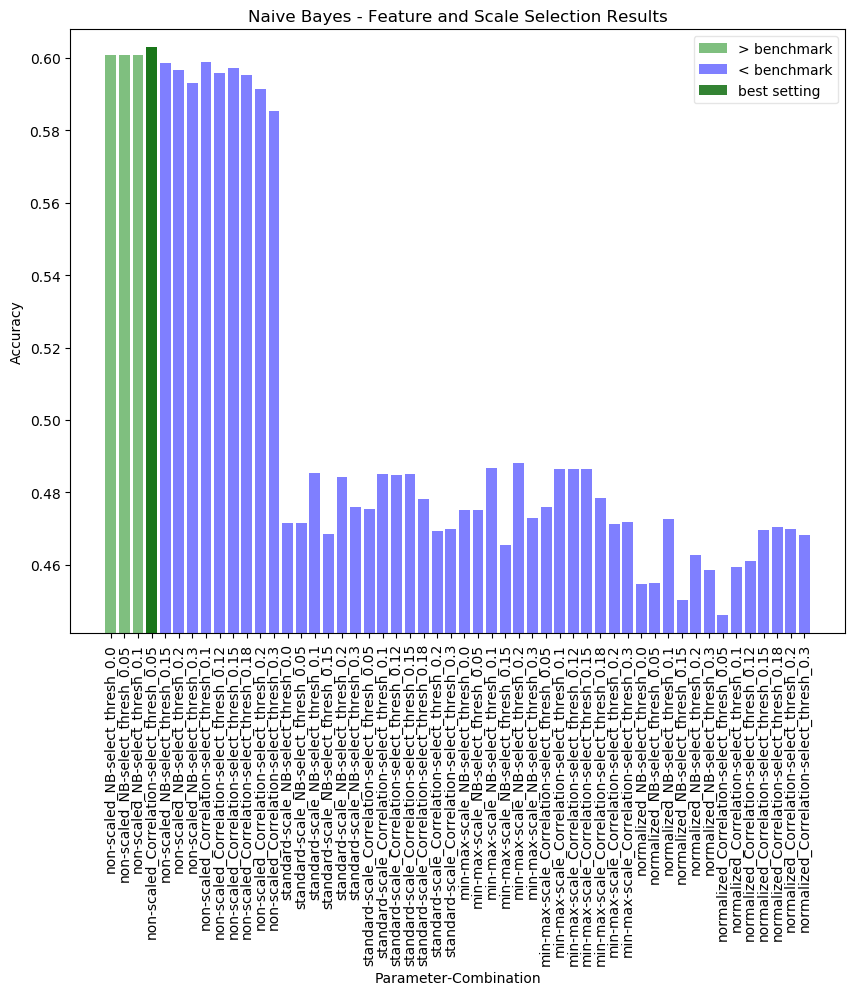

In [113]:
df = pd.read_csv('_results/a.csv')
best_RF = plot_pot(df, 'RF', '_results/RF_transformation_feature_selection_search_1.png', 'Random Forest - Feature and Scale Selection Results')
best_NB = plot_pot(df, 'NB', '_results/NB_transformation_feature_selection_search_1.png', 'Naive Bayes - Feature and Scale Selection Results')

# Best results 
with selecting the best transformation and feature selection parameters
## ALG_1: Random Forest

In [28]:
best_RF

,alg,scale,model_selection,threshold,accuracy,merged
40,RF,standard-scale,Correlation-select,0.1,0.874339,standard-scale_Correlation-select_thresh_0.1


In [74]:
'''build best setting RF dataset'''
i = 1
print('best setting:', scale_name[i])
best_features = all_transformations[i]
best_features[label] = all_labels[i]
best_labels = all_labels[i]

# corr selection
valid_cols = get_selected_correlation_features(best_features, 0.1, label) 

# rf selection
#valid_cols = get_feature_selected_columns(0.05, feat_importances[i],  best_features.columns)

# build train-test data
features_train = best_features[valid_cols].values
labels_train = best_labels.values.ravel()        
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features_train, labels_train, test_size=0.20, random_state=seed)        

best setting: standard-scale


In [75]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=seed)
rf_clf.fit(X_train, y_train)

prediction = rf_clf.predict(X_test)
acc = accuracy_score(y_test, prediction)
acc

0.8743386243386243

#### RF - Hyper Parameter Tuning

In [111]:
import pprint as pp
param_grid = { 
    'n_estimators': [80,90,100,110,120,150,200],
    'max_features': ['auto', 'log2'],
    'max_depth' : [None,2,4,6,8,10],
    'criterion' : ['gini', 'entropy'],
    'bootstrap' : [True, False]
}

model = RandomForestClassifier(n_estimators=100, random_state=seed)
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

In [112]:
param_grid

{'n_estimators': [80, 90, 100, 110, 120, 150, 200],
 'max_features': ['auto', 'log2'],
 'max_depth': [None, 2, 4, 6, 8, 10],
 'criterion': ['gini', 'entropy'],
 'bootstrap': [True, False]}

In [76]:
RF_clf = RandomForestClassifier(max_features = 'auto', 
                                n_estimators = 110, 
                                max_depth = None, 
                                criterion = 'gini',
                                random_state = seed)

RF_clf.fit(X_train, y_train)

prediction = RF_clf.predict(X_test)
acc = accuracy_score(y_test, prediction)
acc

0.8753306878306878

### k-fold-cross validation

In [77]:
scores = cross_val_score(RF_clf, X_train,y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.85 (+/- 0.02)


### confusion matrix

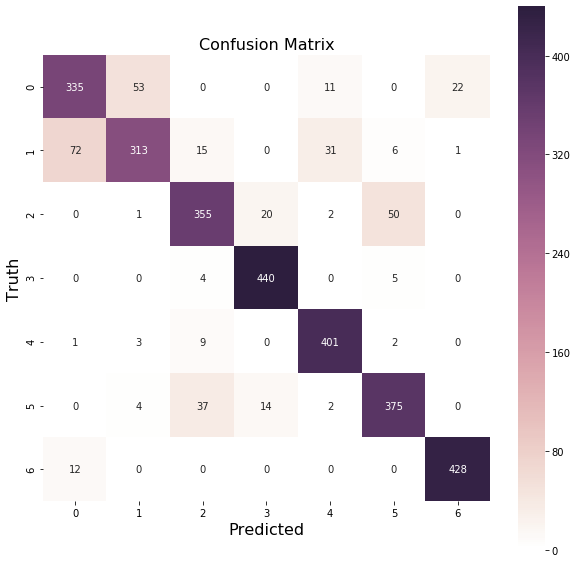

In [80]:
plot_confusion_matrix(y_test, prediction, '_results/RF_confusion_matrix.png')

# ALG_2: Gaussian Naive Bayes

In [26]:
best_NB

,alg,scale,model_selection,threshold,accuracy,merged
13,NB,non-scaled,Correlation-select,0.05,0.602844,non-scaled_Correlation-select_thresh_0.05


In [81]:
'''build best setting NB dataset'''
i = 0
print('best setting:', scale_name[i])
best_features = all_transformations[i]
best_features[label] = all_labels[i]
best_labels = all_labels[i]

# corr selection
valid_cols = get_selected_correlation_features(best_features, 0.05, label)

# build train-test data
features_train = best_features[valid_cols].values
labels_train = best_labels.values.ravel()        
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features_train, labels_train, test_size=0.20, random_state=seed)        

best setting: non-scaled


In [82]:
NB_clf = GaussianNB()
y_pred = NB_clf.fit(X_train,y_train)
prediction = NB_clf.predict(X_test)
acc = accuracy_score(y_test, prediction)
acc

0.6028439153439153

#### NB - Hyper Parameter Tuning

Since naive bayes has no parameters to tune (all occurence probabilities of each feature for each class are multiplied) we can not grid-search for any optimal parameters.

### k-fold-cross validation

In [83]:
scores = cross_val_score(NB_clf, X_train,y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.60 (+/- 0.02)


### confusion matrix

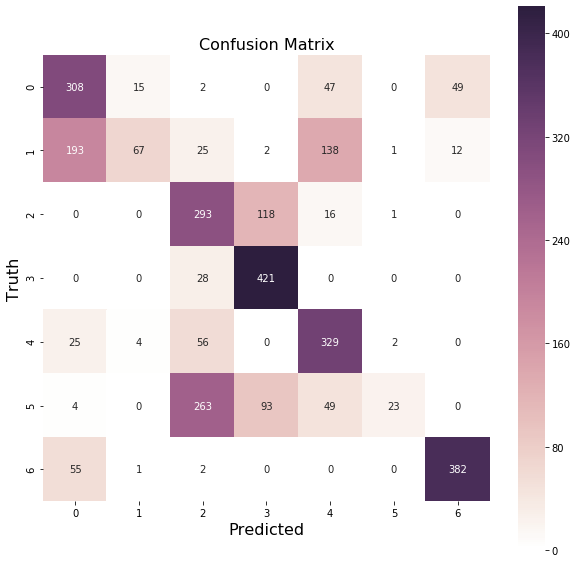

In [84]:
plot_confusion_matrix(y_test, prediction, '_results/NB_confusion_matrix.png')

# < END >